# Data Processing

## Load Metadata

In [2]:
from io import BytesIO
from office365.runtime.auth.authentication_context import AuthenticationContext
from office365.sharepoint.client_context import ClientContext
import pandas as pd

pd.set_option('display.max_columns', 200)

# Constants for the SharePoint connection
TENANT_ID = "c9dc265f-a55d-466a-920c-9eb2e81f750f"
N2_URL = "https://n2applied.sharepoint.com/sites/"
APPLICATION_ID = "f83dae31-1ffa-4457-8e00-bc48c0f02a29"

def authenticate_sharepoint(site_name: str):
    """Authenticate and return a client context for a SharePoint site."""
    site_url = f'{N2_URL}{site_name}'
    ctx_auth = AuthenticationContext(url=site_url)
    ctx_auth.with_interactive(TENANT_ID, APPLICATION_ID)
    ctx = ClientContext(site_url, ctx_auth)
    return ctx

def download_file(ctx: ClientContext, folder_path: str, file_name: str):
    """Download a file from SharePoint."""
    file_path = f'{folder_path}/{file_name}'
    with open(file_name, "wb") as file:
        ctx.web.get_file_by_server_relative_url(file_path).download(file).execute_query()

def load_excelsheet(ctx: ClientContext, folder_path: str, file_name: str, sheet_name: str) -> pd.DataFrame:
    """Load an Excel sheet from SharePoint into a pandas DataFrame."""
    file_path = f'{folder_path}/{file_name}'
    excel_file = ctx.web.get_file_by_server_relative_url(file_path)
    file_content = excel_file.get_content().execute_query()
    excel_sheet = pd.read_excel(io=BytesIO(file_content.value), sheet_name=sheet_name, skiprows=8)
    return excel_sheet

if __name__ == "__main__":
    # Fill in these variables with your specific values
    site_name = 'RD'  # Replace with your actual site name
    folder_path = "Projects/Yara-N2, Effect of oxygen in PNG/WP8_Oxygen_Experimental"  # Replace with your actual folder path
    file_name = "2025-Testplan_and_log_WP8-Oxygen.xlsx"  # Replace with your actual file name
    sheet_name = '2024-1076-Testlog'  # Replace with the sheet name you want
    # Authenticate and obtain client context
    ctx = authenticate_sharepoint(site_name)
    # Download the file
    download_file(ctx, folder_path, file_name)
    # Load the Excel sheet into a DataFrame
    excel_data = load_excelsheet(ctx, folder_path, file_name, sheet_name)

## Filter Metadata

In [3]:
metadata_df = excel_data.copy()

metadata_df = metadata_df[['Test_ID', 'Run Order', 'Date [yyyy.mm.dd]', 'HW start Time [hh:mm]',
       'Exp start Time [hh:mm]', 'Exp stop Time [hh:mm]', 'Duration [min]',
       'Test OK 1=OK', 
       'Quench diameter [mm]', 
       'Target Power [kW]', 'Back pressure PT2001 [barg]',
       'Target enthalpy [kWh/Nm³]', 
       'Oxygen Percentage',
       'Setpoint total gasflow [Nm³/h]', 'Setpoint airflow FV2201 [Nm³/h]',
       'Setpoint Oxygen flow [Nm³/h]', 
       'FTIR channel', 'Current [A]'
       ]]

# dropped non valid rows
metadata_df.dropna(subset=['Exp start Time [hh:mm]', 'FTIR channel'], inplace=True)

# Only include rows where Test OK = 1
# metadata_df = metadata_df.query('`Test OK 1=OK` == 1')

# metadata_df = metadata_df.query('`Test OK 1=OK` != 1')
metadata_df.count()

Test_ID                            32
Run Order                          32
Date [yyyy.mm.dd]                  32
HW start Time [hh:mm]              32
Exp start Time [hh:mm]             32
Exp stop Time [hh:mm]              32
Duration [min]                     32
Test OK 1=OK                       32
Quench diameter [mm]               32
Target Power [kW]                  32
Back pressure PT2001 [barg]        32
Target enthalpy [kWh/Nm³]          32
Oxygen Percentage                  32
Setpoint total gasflow [Nm³/h]     32
Setpoint airflow FV2201 [Nm³/h]    32
Setpoint Oxygen flow [Nm³/h]       32
FTIR channel                       32
Current [A]                         0
dtype: int64

In [4]:
# metadata_df

## Add Timestamps

In [5]:
import pandas as pd
metadata_df['hw_start'] = pd.to_datetime(metadata_df['Date [yyyy.mm.dd]'].astype(str) + ' ' + metadata_df['HW start Time [hh:mm]'].astype(str)).dt.tz_localize('Europe/Oslo')
metadata_df['exp_start'] = pd.to_datetime(metadata_df['Date [yyyy.mm.dd]'].astype(str) + ' ' + metadata_df['Exp start Time [hh:mm]'].astype(str)).dt.tz_localize('Europe/Oslo')
metadata_df['exp_stop'] = pd.to_datetime(metadata_df['Date [yyyy.mm.dd]'].astype(str) + ' ' + metadata_df['Exp stop Time [hh:mm]'].astype(str)).dt.tz_localize('Europe/Oslo')
# metadata_df.tail(1)

## Further Filtering Metadata

In [6]:
test_ids_to_exclude = ['2025-exp4', '2025-exp17', '2025-exp20', '2025-exp21', '2025-exp18', '2025-exp19']
metadata_df = metadata_df[~metadata_df['Test_ID'].isin(test_ids_to_exclude)]

metadata_df_copy = metadata_df.set_index('Test_ID').copy()
metadata_dict = metadata_df_copy.to_dict('index')

# This eliminates need for filtering in subsequent operations
print(f"antall exp = {len(metadata_dict.keys())}\nexcluded = {test_ids_to_exclude}")

antall exp = 26
excluded = ['2025-exp4', '2025-exp17', '2025-exp20', '2025-exp21', '2025-exp18', '2025-exp19']


## Load Sensor Data

In [36]:
from influxdb import InfluxDBClient
import pandas as pd

# Constants
HOST = '192.168.1.3'
DATABASE = 'rnd'
SELECTED_MACHINE = 'TS17'  # Avoid hardcoding by fetching dynamically or using config

# Use a context manager to handle the InfluxDB client connection
with InfluxDBClient(host=HOST, database=DATABASE) as client:
    # Fetch measurements and filter for the selected machine
    measurements = client.query('SHOW MEASUREMENTS')
    selected_machine = next((row['name'] for row in measurements.get_points() if row['name'] == SELECTED_MACHINE), None)

    if not selected_machine:
        raise ValueError(f"Machine '{SELECTED_MACHINE}' not found in measurements.")

    # Fetch equipment and data tag values in a single query
    tag_query = f'SHOW TAG VALUES FROM "{SELECTED_MACHINE}" WITH KEY IN ("equipment", "data")'
    tag_results = client.query(tag_query)

    # Extract equipment and data lists
    equipment_list = [row['value'] for row in tag_results.get_points() if row['key'] == 'equipment']
    data_list = [row['value'] for row in tag_results.get_points() if row['key'] == 'data']

# # Print results
# print("Selected Machine:", selected_machine)
# print("Equipment List:", equipment_list)
# print("Data List:", data_list)

# for equipment in equipment_list:
#      for data in data_list:
#          print(equipment,data)

import pandas as pd
from functools import reduce

# Hardcoded equipment and data lists
f_equipment_list = ['G2101', 'FV2001', 'FV2011', 'TT2204', 'PT2201']
f_data_list = ['arc_voltage', 'arc_power', 'arc_current', 'flow', 'temperature', 'pressure']

# Initialize a dictionary to store DataFrames for each Test ID
sensor_dict = {}

for Test_ID, metadata in metadata_dict.items():
    exp_start = metadata['exp_start']
    exp_stop = metadata['exp_stop']
    
    # Initialize an empty list to store DataFrames for the current Test ID
    dataframes = []
    
    # Iterate over equipment and data lists
    for equipment in f_equipment_list:
        for data in f_data_list:
            query = f"""
            SELECT mean(value) AS mean_value
            FROM {selected_machine}
            WHERE equipment = '{equipment}' AND data = '{data}'
            AND time > '{exp_start.isoformat()}' AND time < '{exp_stop.isoformat()}'
            GROUP BY time(30s, -30s)
            """
            data_points = client.query(query)
            data_rows = list(data_points.get_points())
            
            if data_rows:
                # Create a DataFrame for the current equipment and data
                temp_df = pd.DataFrame({
                    'timestamp': pd.to_datetime([dp['time'] for dp in data_rows]).tz_convert('Europe/Oslo'),
                    f'{equipment}({data})': [dp['mean_value'] for dp in data_rows]
                })

                # Append the DataFrame to the list
                dataframes.append(temp_df)
    
    # Merge all DataFrames for the current Test ID on the 'timestamp' column
    if dataframes:
        merged_sensor_df = reduce(lambda left, right: pd.merge(left, right, on='timestamp', how='outer'), dataframes)
        # merged_sensor_df.set_index('timestamp', inplace=True)
    else:
        merged_sensor_df = pd.DataFrame()

    # Store the merged DataFrame in the dictionary with Test ID as the key
    sensor_dict[Test_ID] = merged_sensor_df

merged_sensor_df.to_pickle('merged_sensor_df.csv')

## Load FTIR Data

In [8]:
from influxdb import InfluxDBClient
import pandas as pd

# Constants
HOST = '192.168.1.3'
DATABASE = 'instruments'
SELECTED_MACHINE = 'protea_ftir_2'  # Avoid hardcoding by fetching dynamically or using config

# Use a context manager to handle the InfluxDB client connection
with InfluxDBClient(host=HOST, database=DATABASE) as client:
    # Fetch measurements and filter for the selected machine
    measurements = client.query('SHOW MEASUREMENTS')
    selected_machine = next((row['name'] for row in measurements.get_points() if row['name'] == SELECTED_MACHINE), None)

    if not selected_machine:
        raise ValueError(f"Machine '{SELECTED_MACHINE}' not found in measurements.")

    # Fetch equipment and data tag values in a single query
    tag_query = f'SHOW TAG VALUES FROM "{SELECTED_MACHINE}" WITH KEY IN ("equipment", "data")'
    tag_results = client.query(tag_query)

    # Extract equipment and data lists
    equipment_list = [row['value'] for row in tag_results.get_points() if row['key'] == 'equipment']
    data_list = [row['value'] for row in tag_results.get_points() if row['key'] == 'data']

# # Print results
# print("Selected Machine:", selected_machine)
# print("Equipment List:", equipment_list)
# print("Data List:", data_list)

# for equipment in equipment_list:
#      for data in data_list:
#          print(equipment,data)

import pandas as pd
from functools import reduce

# Hardcoded equipment and data lists
f_equipment_list = ['Channel_2']
f_data_list = ['NO_Corrected', 'NO2_Corrected']

# Initialize a dictionary to store DataFrames for each Test ID
ftir_dict = {}

for Test_ID, metadata in metadata_dict.items():
    exp_start = metadata['exp_start']
    exp_stop = metadata['exp_stop']
    
    # Initialize an empty list to store DataFrames for the current Test ID
    dataframes = []
    
    # Iterate over equipment and data lists
    for equipment in f_equipment_list:
        for data in f_data_list:
            query = f"""
            SELECT mean(value) AS mean_value
            FROM {selected_machine}
            WHERE equipment = '{equipment}' AND data = '{data}'
            AND time > '{exp_start.isoformat()}' AND time < '{exp_stop.isoformat()}'
            GROUP BY time(30s, -30s)
            """
            data_points = client.query(query)
            data_rows = list(data_points.get_points())
            
            if data_rows:
                # Create a DataFrame for the current equipment and data
                temp_df = pd.DataFrame({
                    'timestamp': pd.to_datetime([dp['time'] for dp in data_rows]).tz_convert('Europe/Oslo'),
                    f'{equipment}({data})': [dp['mean_value'] for dp in data_rows]
                })

                # Append the DataFrame to the list
                dataframes.append(temp_df)
    
    # Merge all DataFrames for the current Test ID on the 'timestamp' column
    if dataframes:
        merged_ftir_df = reduce(lambda left, right: pd.merge(left, right, on='timestamp', how='outer'), dataframes)
        # merged_ftir_df.set_index('timestamp', inplace=True)
    else:
        merged_ftir_df = pd.DataFrame()
    
    # Store the merged DataFrame in the dictionary with Test ID as the key
    ftir_dict[Test_ID] = merged_ftir_df

## Merge Sensor and FTIR Data

In [9]:
# Check column names in sensor_dict
print(sensor_dict[Test_ID].columns)
# Check column names in ftir_dict
print(ftir_dict[Test_ID].columns)


Index(['timestamp', 'G2101(arc_voltage)', 'G2101(arc_power)',
       'G2101(arc_current)', 'FV2001(flow)', 'FV2001(temperature)',
       'FV2001(pressure)', 'FV2011(flow)', 'TT2204(temperature)',
       'PT2201(pressure)'],
      dtype='object')
Index(['timestamp', 'Channel_2(NO_Corrected)', 'Channel_2(NO2_Corrected)'], dtype='object')


In [10]:
# Initialize a dictionary to store merged results
merged_dict = {}

# Iterate over the keys (Test_IDs)
for Test_ID in sensor_dict.keys():
    # Merge the DataFrames from both dictionaries on the 'timestamp' column
    influx_df = pd.merge(sensor_dict[Test_ID], ftir_dict[Test_ID], on='timestamp', how='outer')

    influx_df['NO/NO2'] = influx_df['Channel_2(NO_Corrected)'] / influx_df['Channel_2(NO2_Corrected)']
    influx_df['NOx%'] = influx_df['Channel_2(NO_Corrected)'] + influx_df['Channel_2(NO2_Corrected)']
    influx_df['FV2001(flow)+FV2011(flow)'] = influx_df['FV2001(flow)'] + influx_df['FV2011(flow)']
    std_temp = 273
    std_pressure = 101325
    Mol_mas_N = 14
    R = 8.3145
    influx_df['EC_calc'] = (100000 * std_temp * R * influx_df['G2101(arc_power)']) / (std_pressure * Mol_mas_N * influx_df['FV2001(flow)+FV2011(flow)'] * influx_df['NOx%'])

    influx_df['enthalpy_calc'] = influx_df['G2101(arc_power)'] / influx_df['FV2001(flow)+FV2011(flow)']

    A = influx_df['FV2001(flow)']/influx_df['FV2001(flow)+FV2011(flow)']
    influx_df['O2%_calc'] = (0.995 - A*(0.995-0.2095))*100
    # Store the merged DataFrame in the dictionary with Test ID as the key
    merged_dict[Test_ID] = influx_df

# Concatenate all DataFrames in merged_dict into one large DataFrame
merged_influx_df = pd.concat(merged_dict.values(), ignore_index=True)

print(merged_influx_df['EC_calc'].isna().sum())
merged_influx_df = merged_influx_df.dropna(subset=['EC_calc'])
print(merged_influx_df['EC_calc'].isna().sum())


11
0


## Create Statistical Dataframe

In [11]:
import pandas as pd

stat_dict = {}

# Iterate over the keys (Test_IDs)
for Test_ID in sensor_dict.keys():
    merged_df = pd.merge(sensor_dict[Test_ID], ftir_dict[Test_ID], on='timestamp', how='outer')

    merged_df['NO/NO2']=merged_df['Channel_2(NO_Corrected)']/merged_df['Channel_2(NO2_Corrected)']
    merged_df['NOx%']=merged_df['Channel_2(NO_Corrected)']+merged_df['Channel_2(NO2_Corrected)']
    merged_df['FV2001(flow)+FV2011(flow)']=merged_df['FV2001(flow)']+merged_df['FV2011(flow)']
    
    std_temp = 273
    std_pressure = 101325
    Mol_mas_N = 14
    R = 8.3145
    merged_df['EC_calc'] = (100000*std_temp*R*merged_df['G2101(arc_power)']) / (std_pressure*Mol_mas_N*merged_df['FV2001(flow)+FV2011(flow)']*merged_df['NOx%'])
    merged_df['enthalpy_calc'] = merged_df['G2101(arc_power)'] / merged_df['FV2001(flow)+FV2011(flow)']

    A = merged_df['FV2001(flow)']/(merged_df['FV2001(flow)']+merged_df['FV2011(flow)'])
    merged_df['O2%_calc'] = (0.995-A*(0.995-0.2095))*100

    # Exclude the 'timestamp' column from calculations
    data_columns = merged_df.columns.difference(['timestamp'])
    mean_values = merged_df[data_columns].mean()
    std_values = merged_df[data_columns].std()
    cv_values = std_values / mean_values

    # Store the results in a DataFrame
    stats = {'mean': mean_values, 'std': std_values, 'cv': cv_values}
    stat_df = pd.DataFrame(stats).transpose()
    stat_df['Test_ID'] = Test_ID
    stat_dict[Test_ID] = stat_df

# Concatenate all DataFrames into one
all_stats_df = pd.concat(stat_dict.values(), ignore_index=False)

df = pd.DataFrame()
# For each parameter, append mean, std, cv in order
for parameter in data_columns:
    df = pd.concat(
        [df, 
         all_stats_df.loc['mean', [parameter]].reset_index(drop=True).rename(columns={parameter: parameter + '_mean'}),
         all_stats_df.loc['std', [parameter]].reset_index(drop=True).rename(columns={parameter: parameter + '_std'}),
         all_stats_df.loc['cv', [parameter]].reset_index(drop=True).rename(columns={parameter: parameter + '_cv'})],
        axis=1
    )
# Add Test_ID as a column
df['Test_ID'] = all_stats_df.iloc[::3, all_stats_df.columns.get_loc('Test_ID')].to_list()

print("Reformatted Statistics DataFrame:")
df.head(3)
# print(df.to_string(index=False))

Reformatted Statistics DataFrame:


,Channel_2(NO2_Corrected)_mean,Channel_2(NO2_Corrected)_std,Channel_2(NO2_Corrected)_cv,Channel_2(NO_Corrected)_mean,Channel_2(NO_Corrected)_std,Channel_2(NO_Corrected)_cv,EC_calc_mean,EC_calc_std,EC_calc_cv,FV2001(flow)_mean,FV2001(flow)_std,FV2001(flow)_cv,FV2001(flow)+FV2011(flow)_mean,FV2001(flow)+FV2011(flow)_std,FV2001(flow)+FV2011(flow)_cv,FV2001(pressure)_mean,FV2001(pressure)_std,FV2001(pressure)_cv,FV2001(temperature)_mean,FV2001(temperature)_std,FV2001(temperature)_cv,FV2011(flow)_mean,FV2011(flow)_std,FV2011(flow)_cv,G2101(arc_current)_mean,G2101(arc_current)_std,G2101(arc_current)_cv,G2101(arc_power)_mean,G2101(arc_power)_std,G2101(arc_power)_cv,G2101(arc_voltage)_mean,G2101(arc_voltage)_std,G2101(arc_voltage)_cv,NO/NO2_mean,NO/NO2_std,NO/NO2_cv,NOx%_mean,NOx%_std,NOx%_cv,O2%_calc_mean,O2%_calc_std,O2%_calc_cv,PT2201(pressure)_mean,PT2201(pressure)_std,PT2201(pressure)_cv,TT2204(temperature)_mean,TT2204(temperature)_std,TT2204(temperature)_cv,enthalpy_calc_mean,enthalpy_calc_std,enthalpy_calc_cv,Test_ID
0,1.877811,0.012623,0.006722,1.224932,0.005487,0.004479,51.520973,0.330603,0.006417,27.024774,0.063784,0.002360,27.024774,0.063784,0.002360,4.926498,0.006066,0.001231,23.458379,0.447136,0.019061,0.000000,0.000000,NaN,38.474051,0.198380,0.005156,26.996916,0.104681,0.003878,701.732570,4.522904,0.006445,0.652348,0.005297,0.008120,3.102743,0.013696,0.004414,20.950000,2.856784e-14,1.363620e-15,-0.000164,0.000339,-2.063509,152.537007,0.765566,0.005019,0.998975,0.004646,0.004651,2025-exp3
1,2.210408,0.016624,0.007521,1.152940,0.010917,0.009468,47.576678,0.381071,0.008010,25.607035,0.089769,0.003506,26.978862,0.089795,0.003328,4.834590,0.011759,0.002432,21.116833,1.269461,0.060116,1.371827,0.000416,0.000304,38.997856,0.166940,0.004281,26.978306,0.094684,0.003510,691.704988,3.322697,0.004804,0.521625,0.006306,0.012089,3.363348,0.019797,0.005886,24.944171,1.327720e-02,5.322767e-04,-0.001709,0.000909,-0.531995,152.795879,0.613451,0.004015,0.999990,0.004788,0.004788,2025-exp8
2,2.314227,0.015420,0.006663,1.034995,0.007873,0.007607,43.041342,0.252879,0.005875,26.516473,0.052553,0.001982,29.964592,0.052474,0.001751,5.319640,0.010502,0.001974,23.287500,0.761811,0.032713,3.448119,0.000469,0.000136,36.561276,0.123986,0.003391,26.994574,0.122796,0.004549,738.355938,3.970131,0.005377,0.447260,0.005357,0.011977,3.349221,0.014162,0.004229,29.989020,1.608331e-02,5.363067e-04,0.000000,0.000000,NaN,138.948495,1.255104,0.009033,0.900883,0.004033,0.004477,2025-exp9


## Merge Influx and Metadata

In [12]:
final_df = pd.merge(metadata_df_copy, df, on='Test_ID')
final_df = final_df.drop(columns=[col for col in final_df.columns if 'cv' in col])
final_df.to_csv('final_df.csv')

id = final_df[final_df['Test_ID']=='2025-exp30']
print('exp 30 energy cost =', id['EC_calc_mean'].to_string(index=False))

# final_df.isna().sum()

exp 30 energy cost = 40.851856


## DoE_df

In [13]:
columns = ['Test_ID', 
           'Run Order',

           'O2%_calc_mean',
           'FV2001(flow)_mean',
           'FV2011(flow)_mean',
           'PT2201(pressure)_mean',
           'FV2001(flow)+FV2011(flow)_mean',
           'G2101(arc_current)_mean',

           'EC_calc_mean',
           'Channel_2(NO2_Corrected)_mean',
           'Channel_2(NO_Corrected)_mean',
           'NOx%_mean',
           'G2101(arc_voltage)_mean']
doe_df = final_df[columns]
doe_df.to_csv('doe.csv')
doe_df.tail(3)

,Test_ID,Run Order,O2%_calc_mean,FV2001(flow)_mean,FV2011(flow)_mean,PT2201(pressure)_mean,FV2001(flow)+FV2011(flow)_mean,G2101(arc_current)_mean,EC_calc_mean,Channel_2(NO2_Corrected)_mean,Channel_2(NO_Corrected)_mean,NOx%_mean,G2101(arc_voltage)_mean
23,2025-exp30,30,42.484620,24.470125,9.242291,-0.000646,33.712415,37.058768,40.851856,2.432032,0.705856,3.137888,728.765184
24,2025-exp31,31,50.070127,18.804824,11.078153,-0.001020,29.882977,38.477965,43.662508,2.680836,0.629027,3.309864,701.435133
25,2025-exp32,32,42.540661,21.671761,8.214617,-0.002271,29.886379,38.466708,42.887444,2.661011,0.708584,3.369595,701.690040


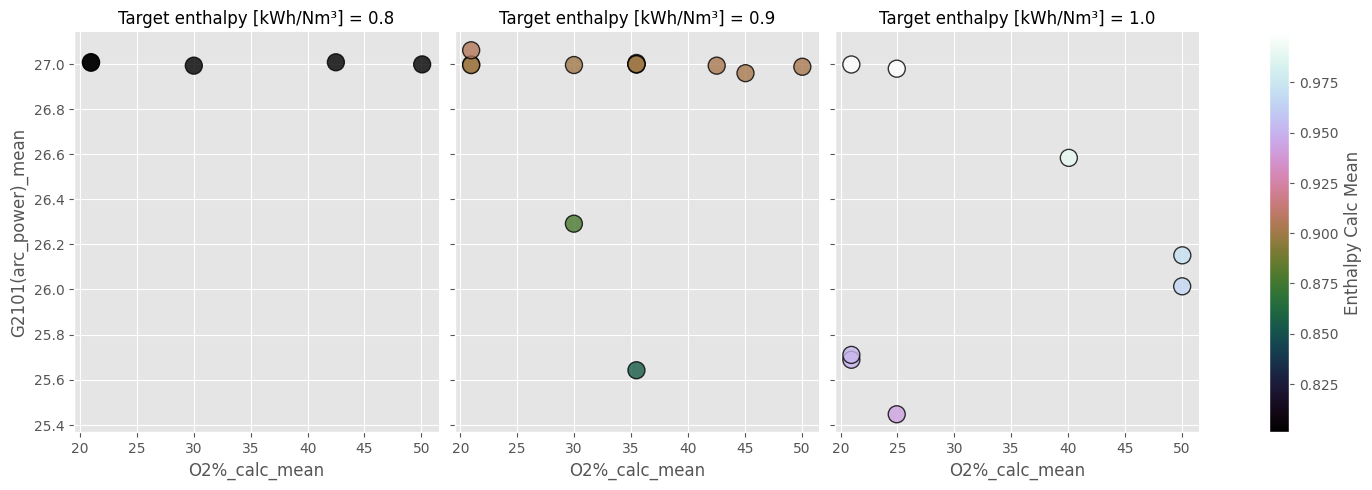

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Create the relplot with hue mapped to 'enthalpy_calc_mean'
g = sns.relplot(
    data=final_df,
    x='O2%_calc_mean',
    y='G2101(arc_power)_mean',
    col='Target enthalpy [kWh/Nm³]',
    s=150,
    alpha=0.8,
    hue='enthalpy_calc_mean',
    legend=False,
    palette='cubehelix',
    marker='o',
    edgecolor='black'
)

# Add a color bar to represent the hue values
norm = plt.Normalize(final_df['enthalpy_calc_mean'].min(), final_df['enthalpy_calc_mean'].max())
sm = plt.cm.ScalarMappable(cmap='cubehelix', norm=norm)
sm.set_array([])

# Adjust the color bar position and size according to your layout
g.fig.colorbar(sm, ax=g.axes, label='Enthalpy Calc Mean')

plt.show()

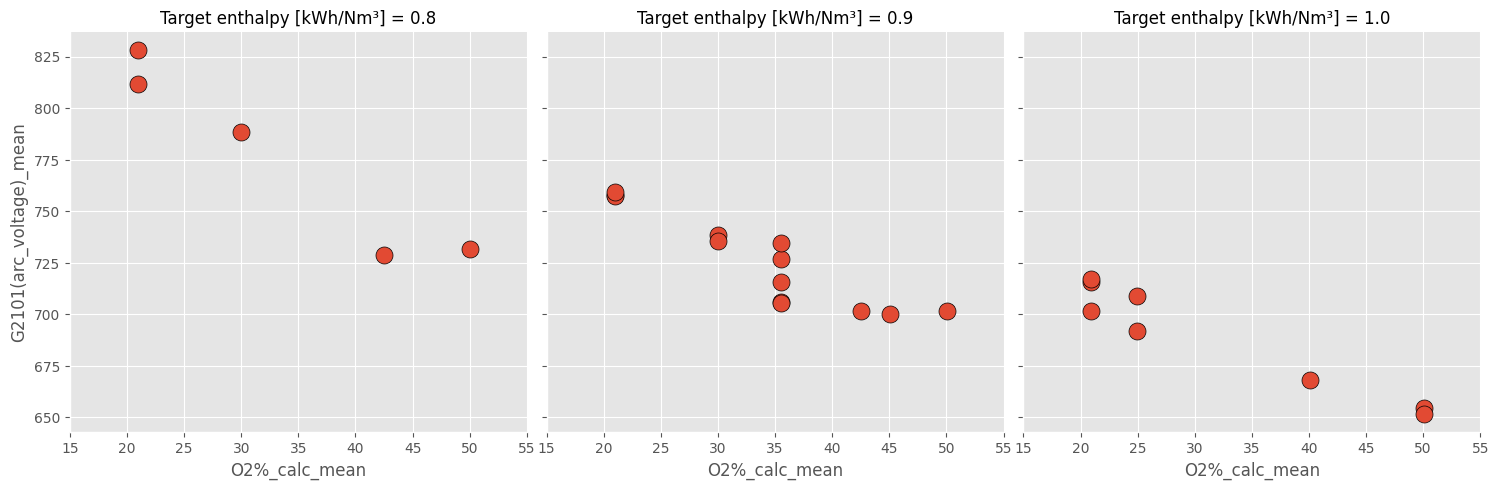

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Create the relplot with hue mapped to 'enthalpy_calc_mean'
g = sns.relplot(
    data=final_df,
    x='O2%_calc_mean',
    y='G2101(arc_voltage)_mean',
    col='Target enthalpy [kWh/Nm³]',
    s=150,
    alpha=1,
    legend=True,
    marker='o',
    edgecolor='black',
    linewidth=0.5,
    col_wrap=3,
    # hue= 'O2%_calc_mean',
    # palette='coolwarm'
    )

g.set_xticklabels(rotation=0)

plt.show()


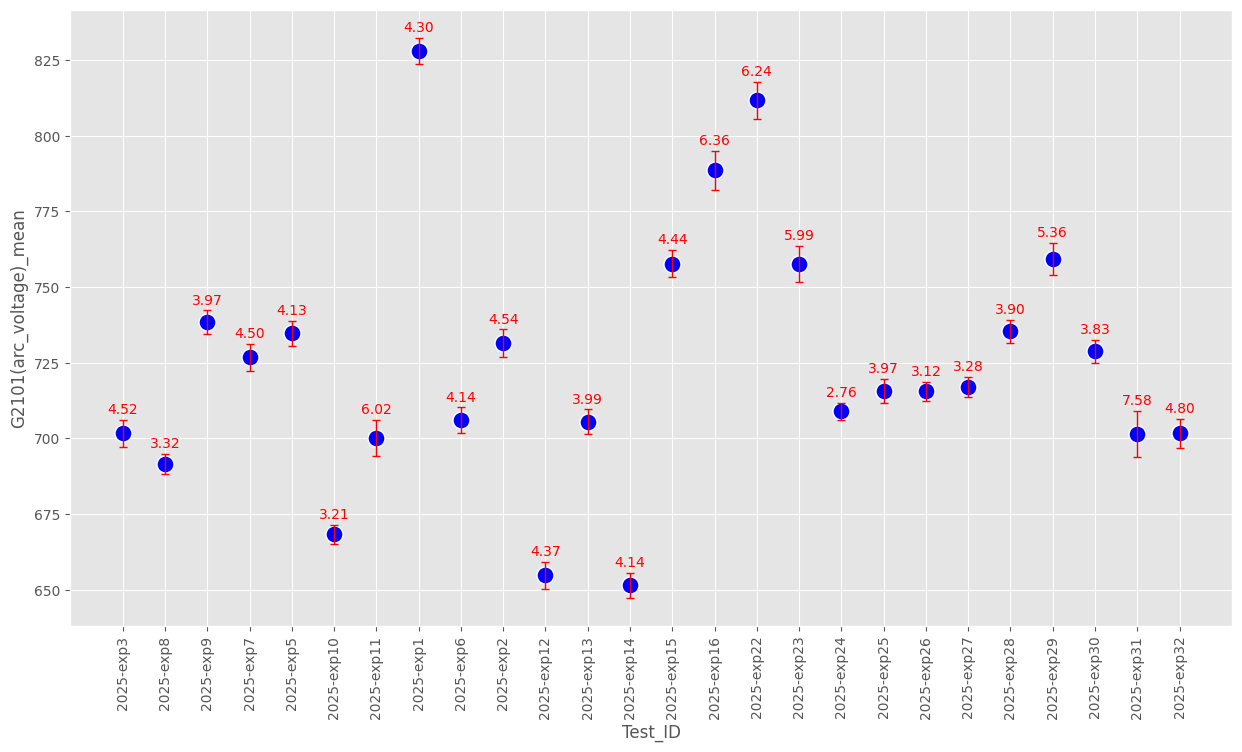

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

test_ids, means, stds = final_df['Test_ID'], final_df['G2101(arc_voltage)_mean'], final_df['G2101(arc_voltage)_std']

fig, ax1 = plt.subplots(figsize=(15, 8))
sns.scatterplot(x=test_ids, y=means, ax=ax1, s=150, color='blue', marker='o')

ax1.errorbar(test_ids, means, yerr=stds, fmt='none', ecolor='red', elinewidth=1, capsize=3)
[ax1.text(i, m + s + 2, f'{s:.2f}', color='red', ha='center') for i, (m, s) in enumerate(zip(means, stds))]

ax1.tick_params(axis='x', rotation=90)
plt.show()

# EDA

In [17]:
import matplotlib.pyplot as plt
plt.style.use('bmh')


## CV

In [18]:
# final_df.columns

In [19]:
# import pandas as pd

# def plot_all_cv_columns_in_one(final_df):
#     columns_cv = ['EC_calc_cv',
#                 'enthalpy_calc_cv',
#                 'G2101(arc_voltage)_cv',
#                 'FV2001(flow)_cv',
#                 'O2%_calc_cv',
#                 'Channel_2(NO_Corrected)_cv',
#                 'Channel_2(NO2_Corrected)_cv']

#     plt.figure(figsize=(15,6))
#     for col in columns_cv:
#         plt.scatter(final_df['Test_ID'], final_df[col], label=col, alpha=0.9, edgecolors='red', s=50, marker='^')
#     plt.title("Scatter plot of _cv columns vs. Test_ID")
#     plt.xlabel('Test_ID')
#     plt.ylabel('Values')
#     plt.xticks(rotation=90)  # Rotate Test_ID labels for better readability
#     plt.legend(title='Columns', bbox_to_anchor=(1, 1.025), loc='upper left')  # Position the legend outside the plot
#     plt.tight_layout()
#     plt.show()

# # Example usage
# plot_all_cv_columns_in_one(final_df)

In [20]:
# import pandas as pd
# import matplotlib.pyplot as plt

# def plot_all_cv_columns_in_one(final_df):
#     # Filter columns that end with '_cv'
#     columns_cv = ['EC_calc_mean',
#                   'EC_calc_std',
#                 ]

   
#     plt.figure(figsize=(25,6))
#     for col in columns_cv:
#         plt.scatter(final_df['Test_ID'], final_df[col], label=col, alpha=0.9, edgecolors='red', s=80, marker='^')
#     plt.title("Scatter plot of _cv columns vs. Test_ID")
#     plt.xlabel('Test_ID')
#     plt.ylabel('Values')
#     plt.xticks(rotation=90)  # Rotate Test_ID labels for better readability
#     plt.legend(title='Columns', bbox_to_anchor=(1, 1.025), loc='upper left')  # Position the legend outside the plot
#     plt.tight_layout()
#     plt.show()

# # Example usage
# plot_all_cv_columns_in_one(final_df)

## Box Plot (Test_IDs)

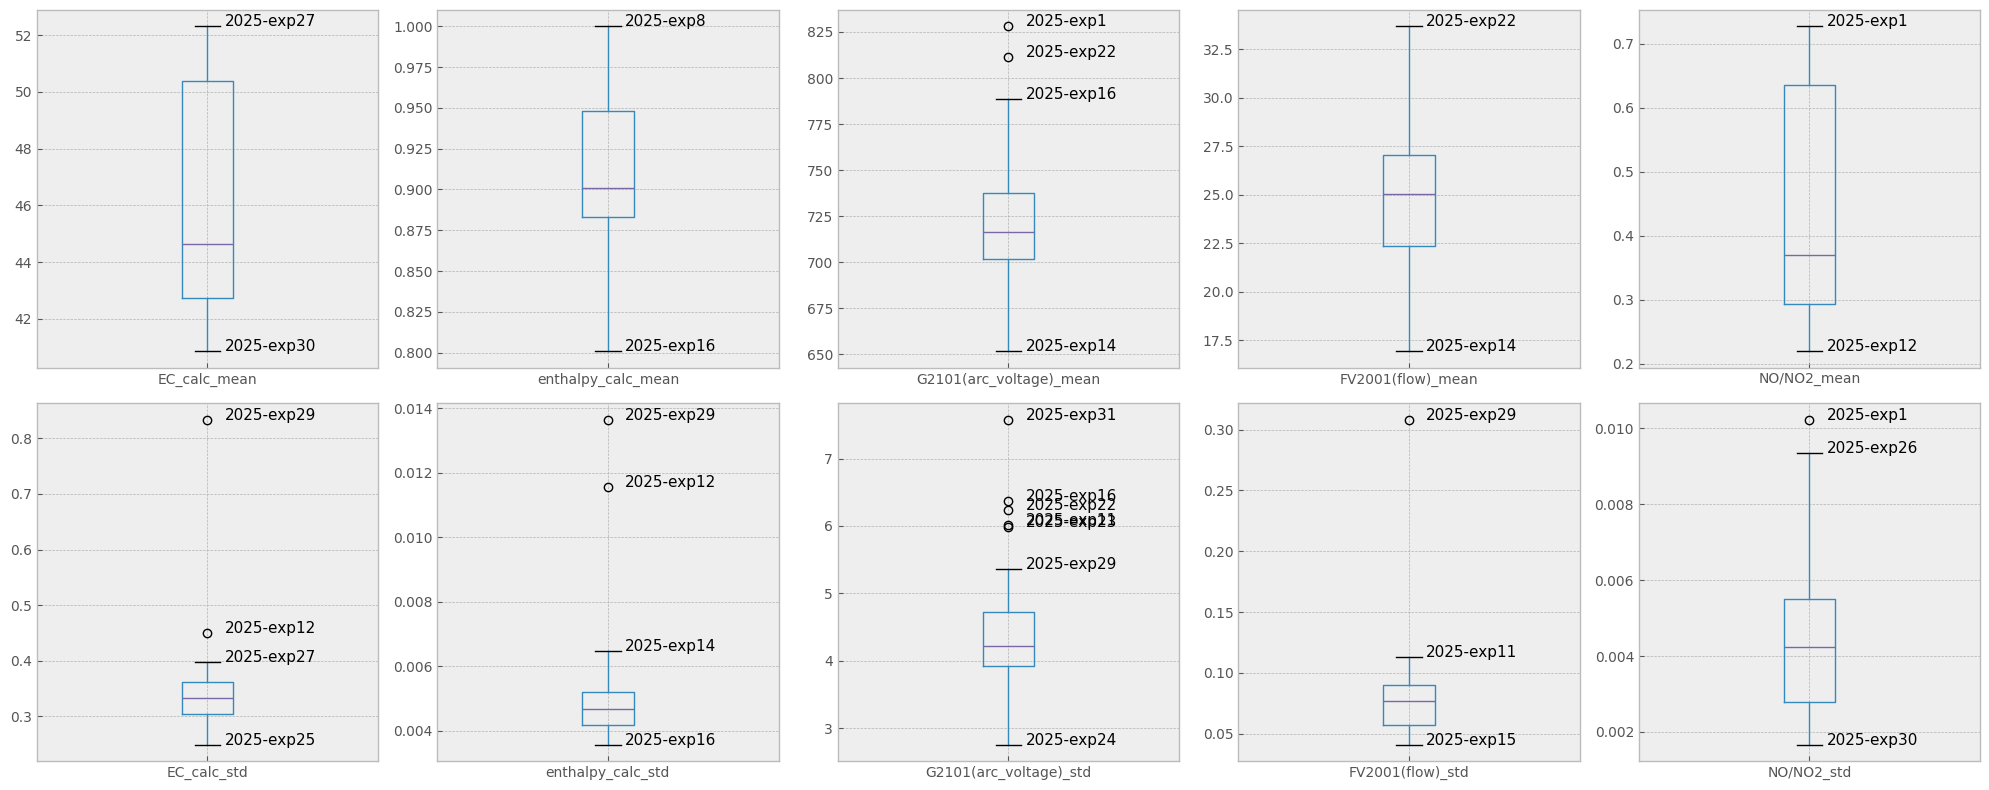

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_boxplots_and_record_ids(df, columns=None):
    # Define number of columns and rows
    ncols, columns_to_plot = 5, columns or df.select_dtypes(include='number').columns
    nrows = int(np.ceil(len(columns_to_plot) / ncols))

    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
    axes = axes.flatten()

    collected_ids = []

    for i, col in enumerate(columns_to_plot):
        df.boxplot(column=col, ax=axes[i])
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr

        # Determine outliers
        outliers = df[(df[col] < low) | (df[col] > high)]

        # Determine non-outlier extrema
        non_outlier_df = df[(df[col] >= low) & (df[col] <= high)]
        extrema = non_outlier_df[col].agg(['min', 'max'])

        # Collect Test_IDs with classification of outliers, min, max
        for idx, row in outliers.iterrows():
            collected_ids.append((row['Test_ID'], col, 'outlier'))

        for val_type in extrema.index:
            extrema_ids = df[df[col] == extrema[val_type]]['Test_ID'].unique()
            for test_id in extrema_ids:
                collected_ids.append((test_id, col, val_type))
        
        # Annotate outliers and extrema
        for idx, row in pd.concat([outliers, df[df[col].isin(extrema)]]).iterrows():
            axes[i].annotate(f"{row['Test_ID']}", xy=(1, row[col]), xytext=(1.05, row[col]), fontsize=11, ha='left')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Return collected Test_IDs with column association and type
    return pd.DataFrame(collected_ids, columns=['Test_ID', 'Column', 'Type'])

# Usage example
test_ids_df = plot_boxplots_and_record_ids(final_df, columns=
                                           ['EC_calc_mean', 
                                            'enthalpy_calc_mean', 
                                            'G2101(arc_voltage)_mean', 
                                            'FV2001(flow)_mean',
                                            'NO/NO2_mean',
                                            'EC_calc_std', 
                                            'enthalpy_calc_std', 
                                            'G2101(arc_voltage)_std', 
                                            'FV2001(flow)_std',
                                            'NO/NO2_std'])
# Display the resulting DataFrame
# print(test_ids_df)

## Selections

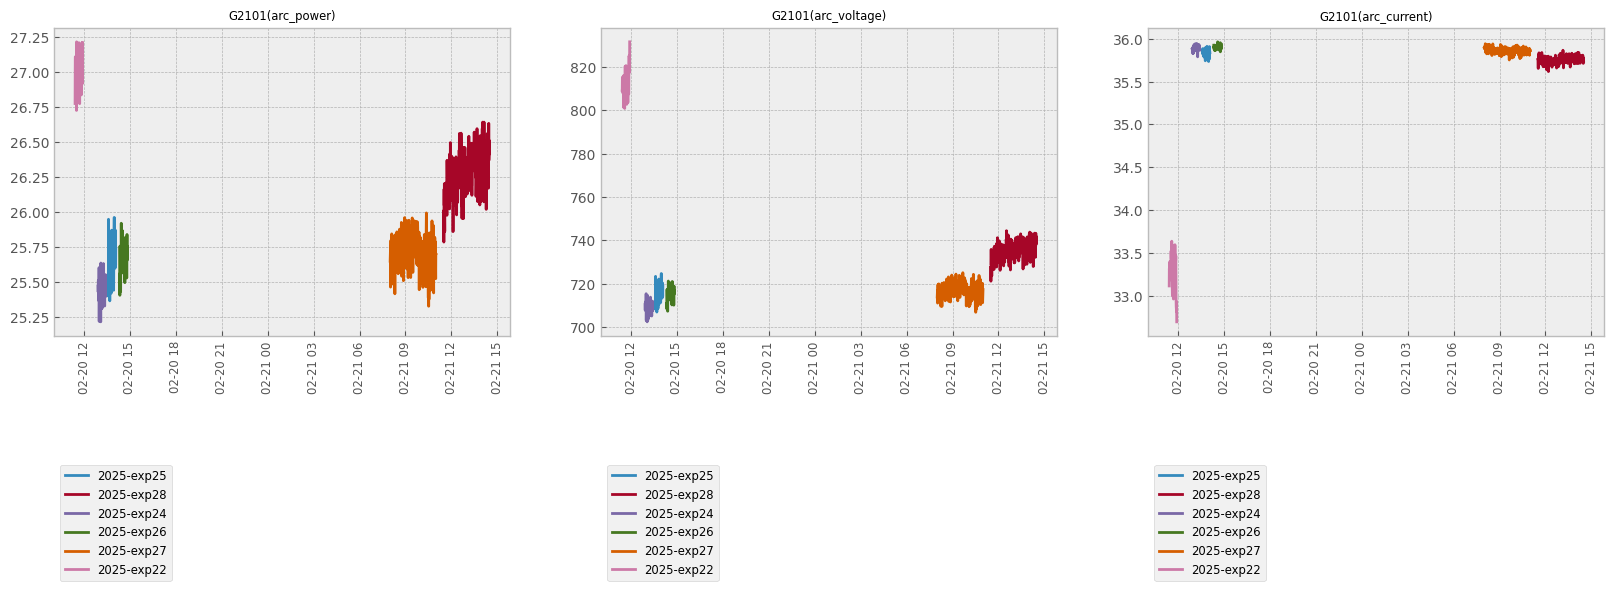

In [22]:
import matplotlib.pyplot as plt

def plot_sensors_for_test_ids(test_ids, sensor_names):
    fig, axes = None, None

    for test_id in test_ids:
        if test_id not in merged_dict:
            print(f"Test ID {test_id} not found in the dataset.")
            continue
            
        df = merged_dict[test_id]
        available_sensors = [name for name in sensor_names if name in df.columns]

        if fig is None:
            num_plots = len(available_sensors)
            num_cols = 3
            num_rows = (num_plots + num_cols - 1) // num_cols
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))
            axes = axes.flatten()

        for i, sensor_name in enumerate(available_sensors):
            timestamp = df['timestamp']
            sensor_data = df[sensor_name]

            axes[i].plot(timestamp, sensor_data, label=f'{test_id}')

            axes[i].tick_params(axis='x', rotation=90, labelsize='small')
            # axes[i].tick_params(axis='y', labelsize='small')
            axes[i].set_title(sensor_name, fontsize='small')
            # axes[i].set_xlabel('Timestamp', fontsize='small')
            # axes[i].set_ylabel(sensor_name, fontsize='small')
            axes[i].legend(loc='upper left', fontsize='small', bbox_to_anchor=(0,-0.4))
            # axes[i].grid(True, linestyle='--', alpha=0.3)

    if fig is not None:
        for j in range(len(available_sensors), len(axes)):
            fig.delaxes(axes[j])

        # plt.subplots_adjust(hspace=0.5, wspace=0.3)
        # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # plt.show()

# Example usage:
plot_sensors_for_test_ids(
   ['2025-exp25', '2025-exp28', '2025-exp24', '2025-exp26', '2025-exp27', '2025-exp22'],

    ['G2101(arc_power)', 'G2101(arc_voltage)', 'G2101(arc_current)',
    #  'Channel_2(NO_Corrected)', 'Channel_2(NO2_Corrected)','NOx%',
    #  'FV2001(flow)', 'FV2011(flow)', 'FV2001(flow)+FV2011(flow)',
    #  'O2%_calc','enthalpy_calc', 'EC_calc', 'TT2204(temperature)'
     ]
)


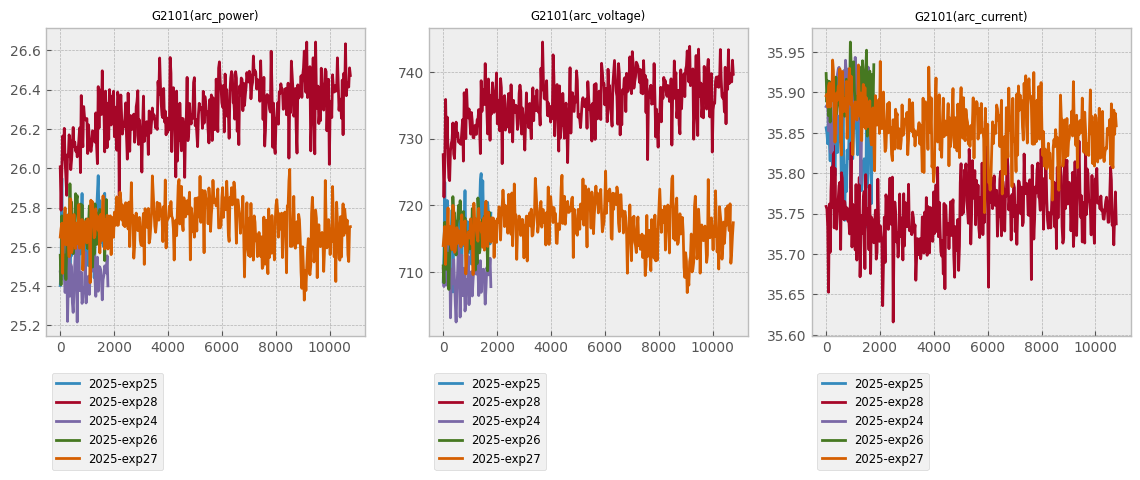

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_sensors_for_test_ids_relative_time(test_ids, sensor_names):
    fig, axes = None, None

    for test_id in test_ids:
        if test_id not in merged_dict:
            print(f"Test ID {test_id} not found in the dataset.")
            continue
        
        df = merged_dict[test_id]
        available_sensors = [name for name in sensor_names if name in df.columns]

        if fig is None:
            num_plots = len(available_sensors)
            num_cols = 3
            num_rows = (num_plots + num_cols - 1) // num_cols
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 4 * num_rows))
            axes = axes.flatten()

        # Calculate relative timestamps
        start_time = pd.to_datetime(df['timestamp'].iloc[0])
        relative_time = (pd.to_datetime(df['timestamp']) - start_time).dt.total_seconds()

        for i, sensor_name in enumerate(available_sensors):
            sensor_data = df[sensor_name]
            axes[i].plot(relative_time, sensor_data, label=f'{test_id}')
            # axes[i].plot(relative_time, sensor_data, label=f'{test_id} - {sensor_name}')

            # axes[i].tick_params(axis='x', rotation=90, labelsize='small')
            # axes[i].tick_params(axis='y', labelsize='small')
            axes[i].set_title(sensor_name, fontsize='small')
            # axes[i].set_xlabel('Relative Time (seconds)', fontsize='small')
            # axes[i].set_ylabel(sensor_name, fontsize='small')
            axes[i].legend(loc='upper left', fontsize='small', bbox_to_anchor=(0,-0.1))
            # axes[i].grid(True, linestyle='--', alpha=0.3)

    if fig is not None:
        for j in range(len(available_sensors), len(axes)):
            fig.delaxes(axes[j])

        # plt.subplots_adjust(hspace=0.5, wspace=0.3)
        # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Example usage:
plot_sensors_for_test_ids_relative_time(

    ['2025-exp25', '2025-exp28', '2025-exp24', '2025-exp26', '2025-exp27'],

    ['G2101(arc_power)', 'G2101(arc_voltage)', 'G2101(arc_current)',
    #  'Channel_2(NO_Corrected)', 'Channel_2(NO2_Corrected)','NOx%',
    #  'FV2001(flow)', 'FV2011(flow)', 'FV2001(flow)+FV2011(flow)',
    #  'O2%_calc','enthalpy_calc', 'EC_calc', 'TT2204(temperature)'
     ]
)

## Correlation

             Variable        VIF
0       O2%_calc_mean  10.158622
1  enthalpy_calc_mean  10.158622


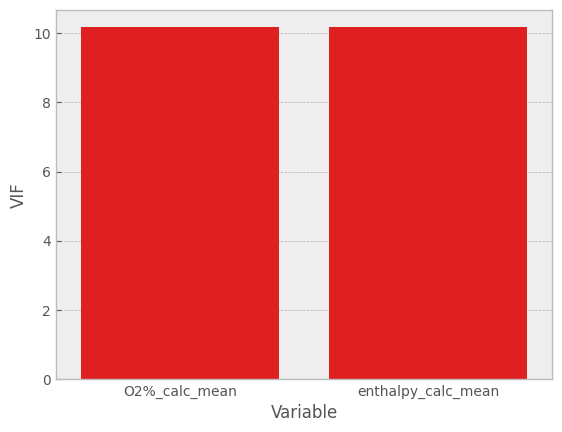

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

variables = final_df[[
    'O2%_calc_mean', 
    'enthalpy_calc_mean'
    ]]

vif_data = pd.DataFrame()
vif_data["Variable"] = variables.columns
vif_data["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(len(variables.columns))]

print(vif_data)

sns.barplot(data=vif_data, x="Variable", y="VIF", color="r")
plt.show()

## Distance Correlation Matrix

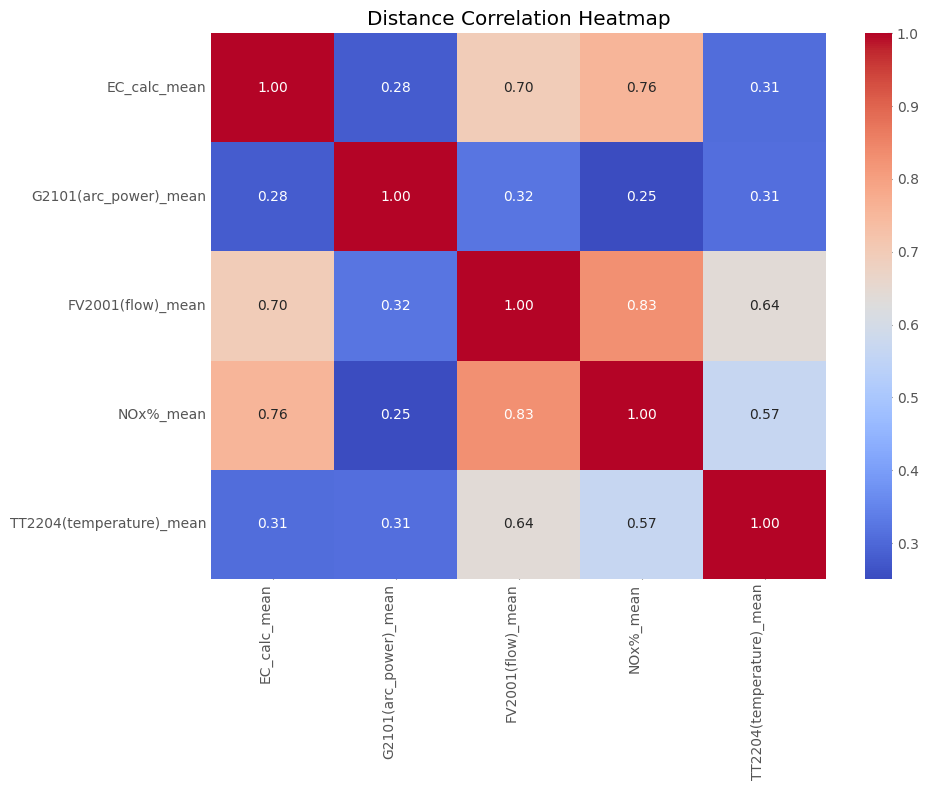

In [25]:
import dcor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming final_df is your DataFrame and you've already selected the columns
selected_columns = [
    'EC_calc_mean',
    'G2101(arc_power)_mean',
    'FV2001(flow)_mean',
    'NOx%_mean',
    'TT2204(temperature)_mean'
]

interaction_df = final_df[selected_columns].copy()

# Initialize a DataFrame to store the distance correlations
dist_corr_df = pd.DataFrame(index=selected_columns, columns=selected_columns)

# Calculate pairwise distance correlations
for i, col1 in enumerate(selected_columns):
    for col2 in selected_columns[i:]:
        dist_corr_value = dcor.distance_correlation(interaction_df[col1], interaction_df[col2])
        dist_corr_df.loc[col1, col2] = dist_corr_value
        dist_corr_df.loc[col2, col1] = dist_corr_value

# Generate the heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(dist_corr_df.astype(float), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Distance Correlation Heatmap')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Show the heatmap
plt.show()


## Checks All Tests on one Sensor

In [26]:
import matplotlib.pyplot as plt

def plot_sensor_data(sensor_name):
    # Filter dict to contain only dataframes with the desired column
    filtered_dict = {key: df for key, df in merged_dict.items() if sensor_name in df.columns}

    # Determine the number of subplots needed
    num_plots = len(filtered_dict)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols

    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))
    axes = axes.flatten()

    # Iterate over the filtered dictionary and plot the sensor data
    for i, (key, df) in enumerate(filtered_dict.items()):
        # Plot the sensor data
        timestamp = df['timestamp']
        sensor_data = df[sensor_name]
        
        axes[i].plot(timestamp, sensor_data, label=f'{key} - {sensor_name}')
        
        # Calculate the mean and standard deviation
        mean_val = sensor_data.mean()
        std_val = sensor_data.std()

        # Plot mean and std lines with lower alpha and thinner lines
        axes[i].axhline(mean_val, color='green', linestyle='-', alpha=0.5, linewidth=1, label=f'Mean ({mean_val:.2f})')
        axes[i].axhline(mean_val + std_val, color='red', linestyle='--', alpha=0.5, linewidth=1, label=f'Mean + Std ({std_val:.2f})')
        axes[i].axhline(mean_val - std_val, color='blue', linestyle='--', alpha=0.5, linewidth=1, label=f'Mean - Std ({std_val:.2f})')

        # Add legend and labels
        axes[i].legend(bbox_to_anchor=(1, 1.02))
        axes[i].tick_params(axis='x', rotation=90)
        axes[i].set_title(f'{key} - {sensor_name}')
        axes[i].set_xlabel('Timestamp')
        axes[i].set_ylabel(sensor_name)

    # Remove any unused subplots
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [27]:
# plot_sensor_data('G2101(arc_voltage)')

# EDA 2

## 1 Groupby Enthalpy

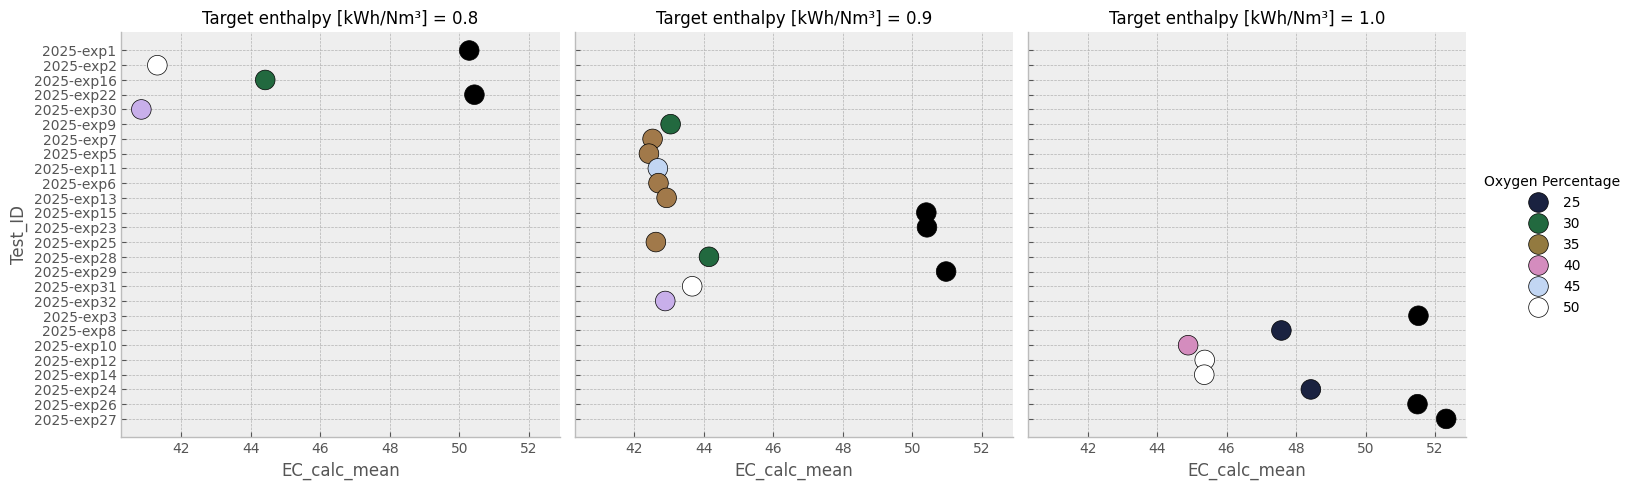

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the relplot with hue mapped to 'enthalpy_calc_mean'
g = sns.relplot(
    data=final_df,
    x='EC_calc_mean',
    y='Test_ID',
    col='Target enthalpy [kWh/Nm³]',
    s=200,
    alpha=1,
    legend=True,
    marker='o',
    edgecolor='black',
    linewidth=0.5,
    col_wrap=3,
    hue= 'Oxygen Percentage',
    palette='cubehelix',
)
plt.show()

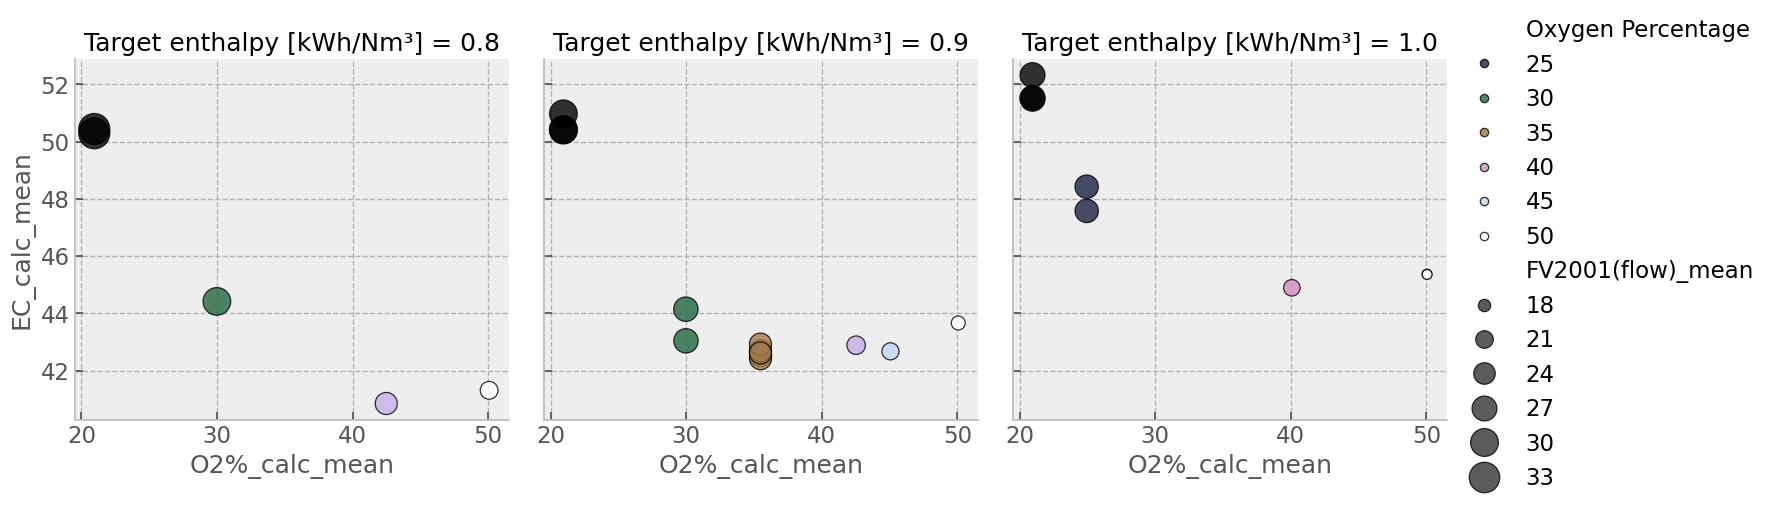

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook', font_scale=1.5)

# Create the relplot with hue mapped to 'enthalpy_calc_mean' and size mapped to another column
g = sns.relplot(
    data=final_df,
    x='O2%_calc_mean',
    y='EC_calc_mean',
    col='Target enthalpy [kWh/Nm³]',
    hue='Oxygen Percentage',
    size='FV2001(flow)_mean',  
    sizes=(50, 500),         
    alpha=0.8,
    legend='brief',
    palette='cubehelix',
    marker='o',
    edgecolor='black',
    linewidth=0.9
)

plt.show()

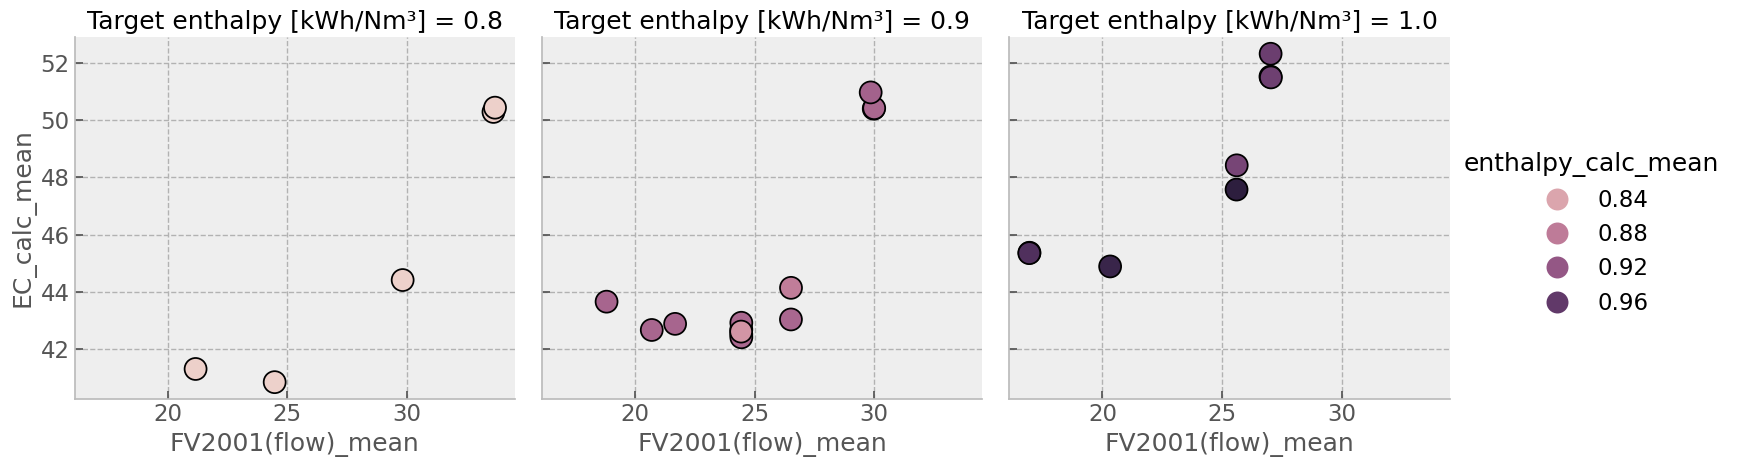

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set_context('notebook', font_scale=1.5)

# Create the relplot with hue mapped to 'enthalpy_calc_mean' and size mapped to another column
g = sns.relplot(
    data=final_df,
    x='FV2001(flow)_mean',
    y='EC_calc_mean',
    col='Target enthalpy [kWh/Nm³]',
    hue='enthalpy_calc_mean',
    s=250,              
    edgecolor='black',
)

plt.show()


In [31]:
final_df.columns

Index(['Test_ID', 'Run Order', 'Date [yyyy.mm.dd]', 'HW start Time [hh:mm]',
       'Exp start Time [hh:mm]', 'Exp stop Time [hh:mm]', 'Duration [min]',
       'Test OK 1=OK', 'Quench diameter [mm]', 'Target Power [kW]',
       'Back pressure PT2001 [barg]', 'Target enthalpy [kWh/Nm³]',
       'Oxygen Percentage', 'Setpoint total gasflow [Nm³/h]',
       'Setpoint airflow FV2201 [Nm³/h]', 'Setpoint Oxygen flow [Nm³/h]',
       'FTIR channel', 'Current [A]', 'hw_start', 'exp_start', 'exp_stop',
       'Channel_2(NO2_Corrected)_mean', 'Channel_2(NO2_Corrected)_std',
       'Channel_2(NO_Corrected)_mean', 'Channel_2(NO_Corrected)_std',
       'EC_calc_mean', 'EC_calc_std', 'FV2001(flow)_mean', 'FV2001(flow)_std',
       'FV2001(flow)+FV2011(flow)_mean', 'FV2001(flow)+FV2011(flow)_std',
       'FV2001(pressure)_mean', 'FV2001(pressure)_std',
       'FV2001(temperature)_mean', 'FV2001(temperature)_std',
       'FV2011(flow)_mean', 'FV2011(flow)_std', 'G2101(arc_current)_mean',
       'G2101

# EDA 3

## Distance correlation

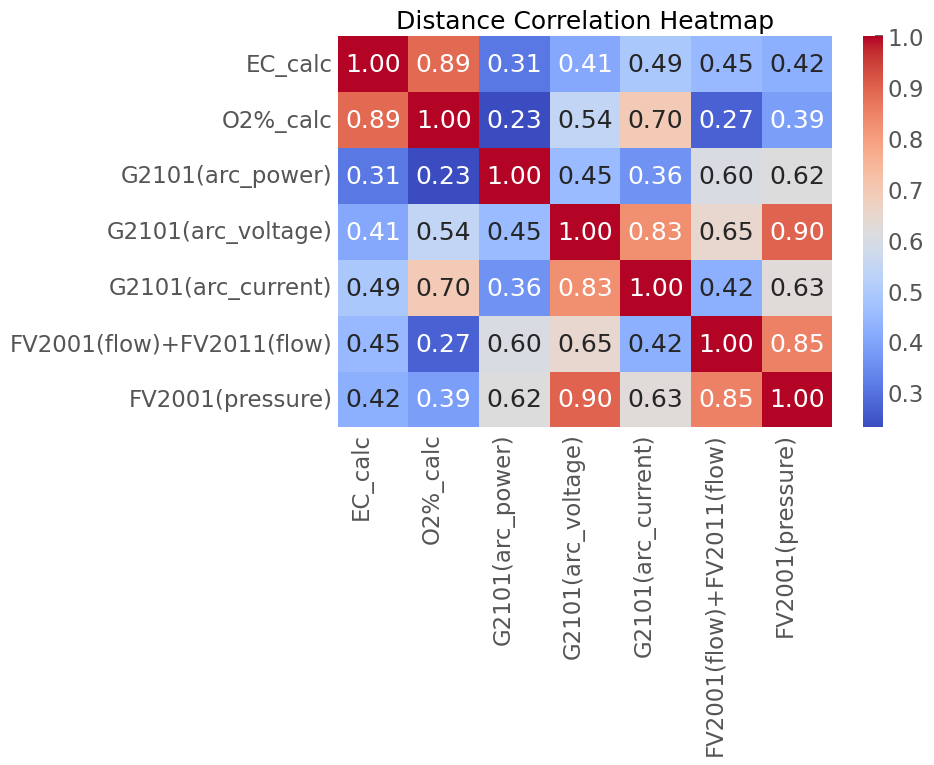

In [39]:
import dcor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming final_df is your DataFrame and you've already selected the columns
selected_columns2 = [
    'EC_calc',
    'O2%_calc',
    'G2101(arc_power)',
    'G2101(arc_voltage)',
    'G2101(arc_current)',
    'FV2001(flow)+FV2011(flow)',
    'FV2001(pressure)'
]

interaction_df = merged_influx_df[selected_columns2].copy()

# Initialize a DataFrame to store the distance correlations
dist_corr_df = pd.DataFrame(index=selected_columns2, columns=selected_columns2)

# Calculate pairwise distance correlations
for i, col1 in enumerate(selected_columns2):
    for col2 in selected_columns2[i:]:
        dist_corr_value = dcor.distance_correlation(interaction_df[col1], interaction_df[col2])
        dist_corr_df.loc[col1, col2] = dist_corr_value
        dist_corr_df.loc[col2, col1] = dist_corr_value

# Generate the heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(dist_corr_df.astype(float), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Distance Correlation Heatmap')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Show the heatmap
plt.show()

## Error %

In [49]:
metadata_df.count()

Test_ID                            26
Run Order                          26
Date [yyyy.mm.dd]                  26
HW start Time [hh:mm]              26
Exp start Time [hh:mm]             26
Exp stop Time [hh:mm]              26
Duration [min]                     26
Test OK 1=OK                       26
Quench diameter [mm]               26
Target Power [kW]                  26
Back pressure PT2001 [barg]        26
Target enthalpy [kWh/Nm³]          26
Oxygen Percentage                  26
Setpoint total gasflow [Nm³/h]     26
Setpoint airflow FV2201 [Nm³/h]    26
Setpoint Oxygen flow [Nm³/h]       26
FTIR channel                       26
Current [A]                         0
hw_start                           26
exp_start                          26
exp_stop                           26
dtype: int64

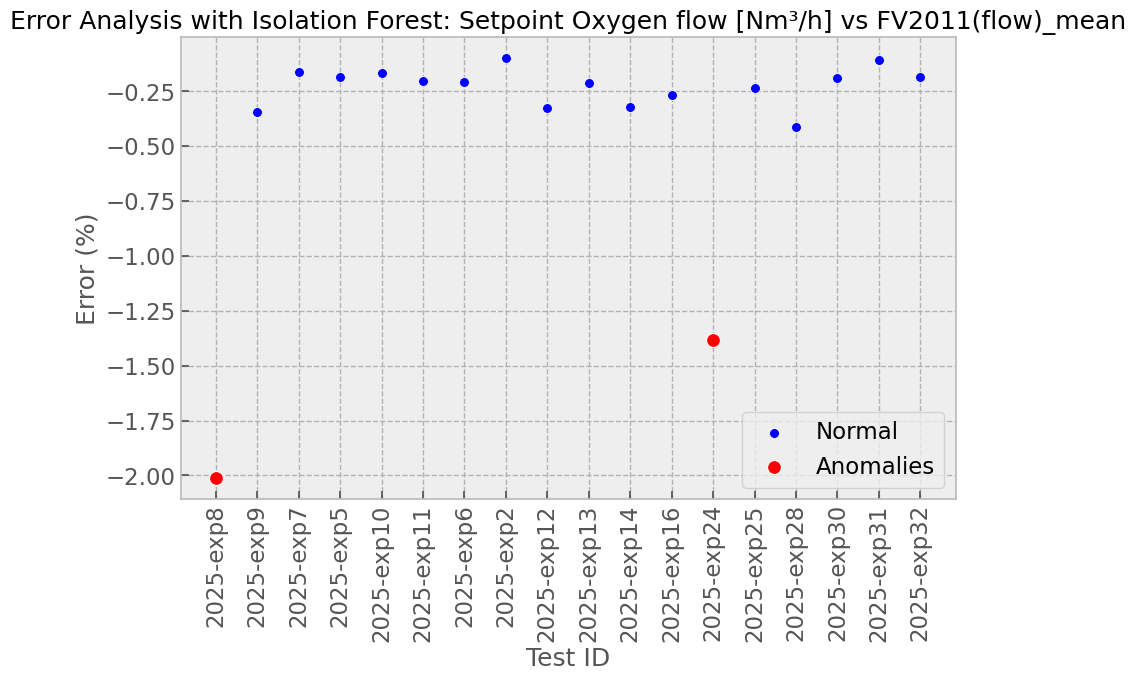

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import pandas as pd

def Error_with_IsolationForest(final_df, target_col, actual_col):
    """
    Calculate Error percentage, plot results, and detect anomalies using Isolation Forest.
    
    Parameters:
        final_df: DataFrame containing the data.
        target_col: Column name for target values.
        actual_col: Column name for actual values.
    """
    # Calculate Error
    target = final_df[target_col]
    actual = final_df[actual_col]
    error = ((actual - target) / target) * 100
    
    # Add the error column to the DataFrame
    final_df['error'] = error
    
    # Drop NaNs (important for Isolation Forest to work)
    final_df.dropna(subset=['error'], inplace=True)
    
    # Initialize and fit the Isolation Forest model
    model = IsolationForest(contamination=0.1, random_state=42)
    final_df['anomaly'] = model.fit_predict(final_df[['error']])
    
    # Separate anomalies
    anomalies = final_df[final_df['anomaly'] == -1]
    
    # Plot Errors
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=final_df['Test_ID'], y=final_df['error'], label='Normal', color='blue', s=50)
    sns.scatterplot(x=anomalies['Test_ID'], y=anomalies['error'], label='Anomalies', color='red', s=100)
    plt.xlabel('Test ID')
    plt.ylabel('Error (%)')
    plt.title(f'Error Analysis with Isolation Forest: {target_col} vs {actual_col}')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

# Example usage
Error_with_IsolationForest(final_df, 'Setpoint Oxygen flow [Nm³/h]', 'FV2011(flow)_mean')
